# Supervised Deep Learning for Segmentation



In [2]:
%matplotlib inline

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = False

In [3]:
conda install pytorch torchvision -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py38hecd8cb5_1         2.9 MB
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following packages will be UPDATED:

  conda                               4.10.0-py38hecd8cb5_0 --> 4.10.1-py38hecd8cb5_1



conda-4.10.1         | 2.9 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from lib.voc import VOCSegmentation

# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined

In [5]:
pip install -U numpy>=1.16.0

zsh:1: 1.16.0 not found
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install chainercv

Note: you may need to restart the kernel to use updated packages.


In [7]:
from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [8]:
# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

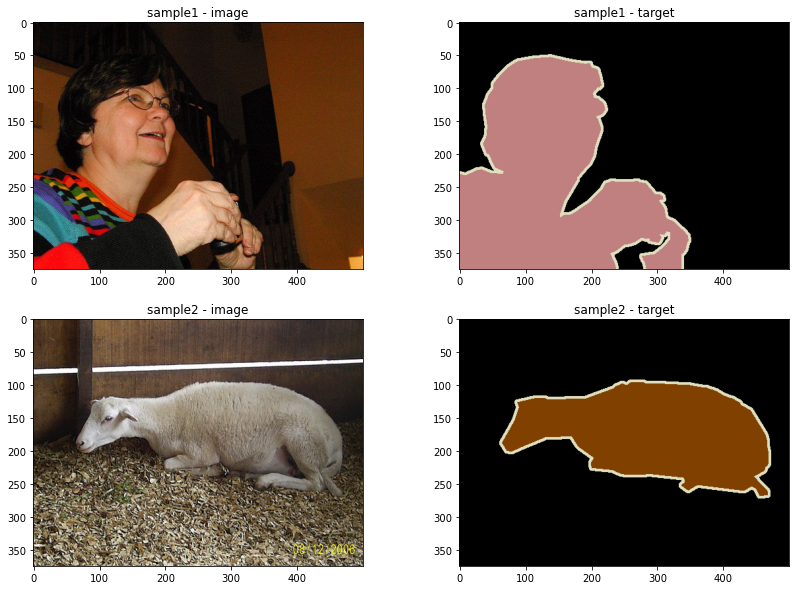

In [10]:
# Below we use a sample image-target pair from VOC training dataset to test your joint transforms. 
# Running this block will automatically download the PASCAL VOC Dataset (3.7GB) to DATASET_PATH 
# if "download = True".
# The code below creates subdirectory "datasets" in the same location as the notebook file, but
# you can modify DATASET_PATH to download the dataset to any custom directory. Download takes a few minutes.
# On subsequent runs you may save time by setting "download = False" (the default value of this flag)

DATASET_PATH = 'datasets'  

# Here, we obtain and visualize one sample (img, target) pair from VOC training dataset and one from validation dataset. 
# Note that operator [...] extracts the sample corresponding to the specified index. 
# Also, note the parameter download = True. Set this to False after you download to save time on later runs.
sample1 = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[200]
sample2 = VOCSegmentation(DATASET_PATH, image_set='val')[20]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

#### Implement a set of "Joint Transform" functions to perform data augmentation in your dataset. 

Neural networks are typically applied to transformed images. There are several important reasons for this: 

1. The image data should is in certain required format (i.e. consistent spacial resolution to batch). The images should also be normalized and converted to the "tensor" data format expected by pytorch libraries. 

2. Some transforms are used to perform randomized image domain transformations with the purpose of "data augmentation". 



#### This class takes a img, target pair, and then transform the pair such that they are in `Torch.Tensor()` format.


In [11]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long()

In [12]:
# Check the transform by passing the image-target sample.

JointToTensor()(*sample1)

(tensor([[[0.0431, 0.0510, 0.0353,  ..., 0.3137, 0.3725, 0.3490],
          [0.0196, 0.0431, 0.0235,  ..., 0.3294, 0.3569, 0.3294],
          [0.0392, 0.0510, 0.0471,  ..., 0.3412, 0.3765, 0.3608],
          ...,
          [0.9412, 0.9961, 1.0000,  ..., 0.9647, 0.9686, 0.9725],
          [1.0000, 0.9686, 0.9961,  ..., 0.9608, 0.9647, 0.9686],
          [1.0000, 0.9490, 1.0000,  ..., 0.9725, 0.9725, 0.9843]],
 
         [[0.0392, 0.0471, 0.0196,  ..., 0.1176, 0.1765, 0.1647],
          [0.0157, 0.0392, 0.0078,  ..., 0.1294, 0.1608, 0.1333],
          [0.0353, 0.0471, 0.0314,  ..., 0.1294, 0.1765, 0.1608],
          ...,
          [0.0157, 0.0667, 0.0706,  ..., 0.6549, 0.6588, 0.6588],
          [0.0784, 0.0431, 0.0667,  ..., 0.6510, 0.6510, 0.6549],
          [0.0745, 0.0235, 0.0784,  ..., 0.6627, 0.6627, 0.6706]],
 
         [[0.0314, 0.0392, 0.0157,  ..., 0.0118, 0.0706, 0.0549],
          [0.0078, 0.0314, 0.0039,  ..., 0.0235, 0.0549, 0.0275],
          [0.0275, 0.0392, 0.0275,  ...,

#### This class implements CenterCrop that takes an img, target pair, and then apply a crop about the center of the image such that the output resolution is $\mbox{size} \times \mbox{size}$.


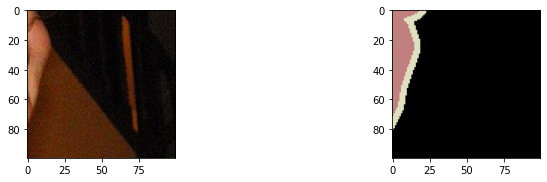

In [13]:
class JointCenterCrop(object):
    def __init__(self, size):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        
    def __call__(self, img, target):
        return (tF.five_crop(img, self.size)[4], 
                tF.five_crop(target, self.size)[4])
    
img, target = JointCenterCrop(100)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### This class should take a img, target pair and then apply a horizontal flip across the vertical axis at random.


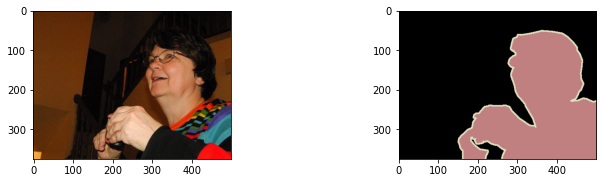

In [14]:
class RandomFlip(object):
    def __call__(self, im, target):
        # we use a random number between 0 and 1 to decide if we should flip
        p = 0.5
        if random.uniform(0, 1) < 0.5:
            return (tF.hflip(im), tF.hflip(target))
        else:
            return (im,target)

# show result
im, target = RandomFlip()(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)


#### This class should take a img, target pair and then resize the images by a random scale between $[\mbox{minimum_scale}, \mbox{maximum_scale}]$, crop a random location of the image by $\min(\mbox{size}, \mbox{image_height}, \mbox{image_width})$ (where the size is passed in as an integer in the constructor), and then resize to $\mbox{size} \times \mbox{size}$ (again, the size passed in). The crop box should fit within the image.


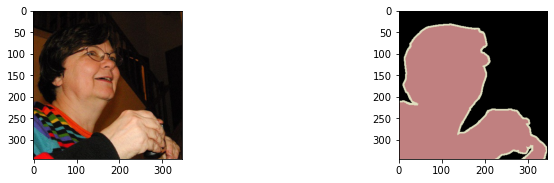

In [15]:
class RandomResizeCorp(object):
    def __init__(self, minimum_scale, maximum_scale, size):
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        self.size = size
    
    def __call__(self, im, target): 
        # use function to get a random scale between self.min_scale and self.max_scale
        scale = np.random.uniform(self.min_scale, self.max_scale)
        # calculate the new size of the im after applying the scale
        new_hight = int(scale * im.size[1])
        new_width = int(scale * im.size[0])
        # resize the image
        im = tF.resize(im, (new_hight, new_width))
        target = tF.resize(target, (new_hight, new_width))
        # calculate the crop_size using min(size,image_height,image_width)
        crop_size = min(self.size, new_width, new_hight)
        # select a random crop location
        # from 0 to width - crop or height - crop(to let crop fit in im)
        crop_y = random.randint(0, new_hight - crop_size)
        crop_x = random.randint(0, new_width - crop_size)
        # tF.resized_crop(img, top, left, height, width, size)
        # note that top is the vertical component, left is the horizontol component
        return (tF.resized_crop(im, crop_y, crop_x, crop_size, crop_size, self.size),
                tF.resized_crop(target, crop_y, crop_x, crop_size, crop_size, self.size))

# show result
im, target = RandomResizeCorp(0.75, 1.5, 345)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)


#### This class should take a img, target pair and then normalize the images by subtracting the mean and dividing variance. 


In [16]:
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]) 

class JointNormalize(object):
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def __call__(self, tensor, target):
        # normalize the image but do not change the target
        return (tF.normalize(tensor, self.mean, self.variance), target)

# show result
tensor = JointToTensor()(*sample1)
JointNormalize(*norm)(*tensor)

(tensor([[[-1.9295, -1.8953, -1.9638,  ..., -0.7479, -0.4911, -0.5938],
          [-2.0323, -1.9295, -2.0152,  ..., -0.6794, -0.5596, -0.6794],
          [-1.9467, -1.8953, -1.9124,  ..., -0.6281, -0.4739, -0.5424],
          ...,
          [ 1.9920,  2.2318,  2.2489,  ...,  2.0948,  2.1119,  2.1290],
          [ 2.2489,  2.1119,  2.2318,  ...,  2.0777,  2.0948,  2.1119],
          [ 2.2489,  2.0263,  2.2489,  ...,  2.1290,  2.1290,  2.1804]],
 
         [[-1.8606, -1.8256, -1.9482,  ..., -1.5105, -1.2479, -1.3004],
          [-1.9657, -1.8606, -2.0007,  ..., -1.4580, -1.3179, -1.4405],
          [-1.8782, -1.8256, -1.8957,  ..., -1.4580, -1.2479, -1.3179],
          ...,
          [-1.9657, -1.7381, -1.7206,  ...,  0.8880,  0.9055,  0.9055],
          [-1.6856, -1.8431, -1.7381,  ...,  0.8704,  0.8704,  0.8880],
          [-1.7031, -1.9307, -1.6856,  ...,  0.9230,  0.9230,  0.9580]],
 
         [[-1.6650, -1.6302, -1.7347,  ..., -1.7522, -1.4907, -1.5604],
          [-1.7696, -1.6650,

#### Use `JointCompose`  to compose the implemented transforms together in some random order. 

In [17]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. This cell is fully implemented.

class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

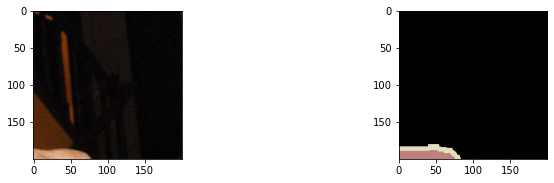

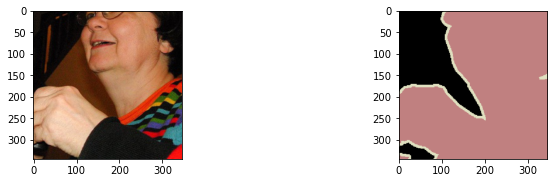

In [18]:

# First example use JointCenterCrop and RandomResizeCorp
# in this example, the image should not flip
trans1 = [RandomResizeCorp(0.75, 1.5, 600), JointCenterCrop(200)]
im01, target01 = JointCompose(trans1)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im01)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target01)

# Second example: use RandomResizeCorp and RandomFlip
trans2 = [RandomResizeCorp(0.75, 1.5, 345), RandomFlip()]
im02, target02 = JointCompose(trans2)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im02)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target02)


#### (e) Compose the transforms together: use `JointCompose` to compose the implemented transforms for:
#### 1. A sanity dataset that will contain 1 single image.
#### 2. A training dataset that will contain the training images. 
#### 3. A validation dataset that will contain the validation images. 

In [19]:

# since we overfit the image, we simply transfer it to tensor and then nomalize it
sanity_joint_transform = JointCompose([JointToTensor(),
                                       JointNormalize(*norm)])

# we need to resize the image, crop it and then transform it to tensor 
# and finally normalize it
# makesure we make all training image have the same size
train_joint_transform =  JointCompose([ RandomResizeCorp(0.8, 1.2, 300), 
                                       JointToTensor(),
                                       JointNormalize(*norm)])

val_joint_transform = JointCompose([JointToTensor(),
                                    JointNormalize(*norm)])



This code below will then apply `train_joint_transform` to the entire dataset.

In [318]:
# Apply the Joint-Compose transformations above to create three datasets and the 
# corresponding Data-Loaders.
# This cell is fully implemented.

# This single image data(sub)set can help to better understand and to debug the network training process. 
# Optional integer parameter 'sanity_check' specifies the index of the image-target pair and creates a single image dataset.
# Note that we use the same image (index=200) as used for sample1.
sanity_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = sanity_joint_transform,
    sanity_check = 200
)

# This is a standard VOC data(sub)set used for training semantic segmentation networks
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = train_joint_transform
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = val_joint_transform
)

# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 4

# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS = 0

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

# Problem 2

#### (a) Implement encoder/decoder segmentation CNN using PyTorch.

We follow the general network architecture specified in the image below. 
<img src="images\deeplabv2_overview.png"> 
We choose specific parameters for all layers according to paper "DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs"

In [319]:
import torchvision.models as models

class MyNet(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(MyNet, self).__init__()
        self.num_class = num_classes
        self.criterion = criterion
        # we use ResNet34 for our model
        # ResNet-34 model from “Deep Residual Learning for Image Recognition”.
        self.used_net = models.resnet34(pretrained=True,progress=True)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,stride=1)
        # some cov and bn layers
        # conv layers
        # kernel size is 7*7, stride is 3
        # note: 576 is 512(size of resnet34) + 64(size after applying layers in resnet34)
        # we use 576 since we need to apply concat
        self.conv1 = nn.Conv2d(576, 250, 7, stride=3,dilation=1)
        #self.conv1 = nn.Conv2d(512, 250, 7, stride=3,dilation=1)
        self.conv2 = nn.Conv2d(250, self.num_class, 1, stride=1,dilation=1)
        # Normalization Layer
        self.bn2d = nn.BatchNorm2d(250)
        
    # note both upsampling, we use bilinear mode
    def forward(self, inp, gts=None):
        original_shape = inp.shape
        # use the resnet
        inp = self.used_net.conv1(inp)
        inp = self.used_net.bn1(inp)
        inp = self.used_net.relu(inp)
        inp = self.used_net.maxpool(inp)       
        # get the copy of inp(used later in concatention)
        original_inp = inp;
        # get the shape of inp before applying layers (used in the first upsampling)
        inp_shape = inp.shape        
        # use the layers of used_net
        inp = self.used_net.layer1(inp)
        inp = self.used_net.layer2(inp)
        inp = self.used_net.layer3(inp)
        inp = self.used_net.layer4(inp)
        # do the first upsampling
        # upsample so that we can apply concatention
        upsample1 = nn.UpsamplingBilinear2d((inp_shape[2],inp_shape[3]))
        inp = upsample1(inp)
        # do concatention
        inp = torch.cat((original_inp,inp),1)
        # applying some layers of conv, relu and bn
        inp = self.conv1(inp) 
        inp = F.relu(inp)
        inp = self.bn2d(inp)
        inp = self.conv2(inp) 
        inp = F.relu(inp)
        # upsample for decoder using bininear interpolation
        # this time, we upsample to the original size
        inp = F.interpolate(inp, size = (original_shape[2], original_shape[3]),
                            mode = 'bilinear')
        # update the final result
        lfinal = inp
        # the given code (donot modify)
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)              
        else:
            # Return the actual prediction otherwise
            return lfinal




#### Create UNTRAINED_NET and run on a sample image

<IPython.core.display.Javascript object>


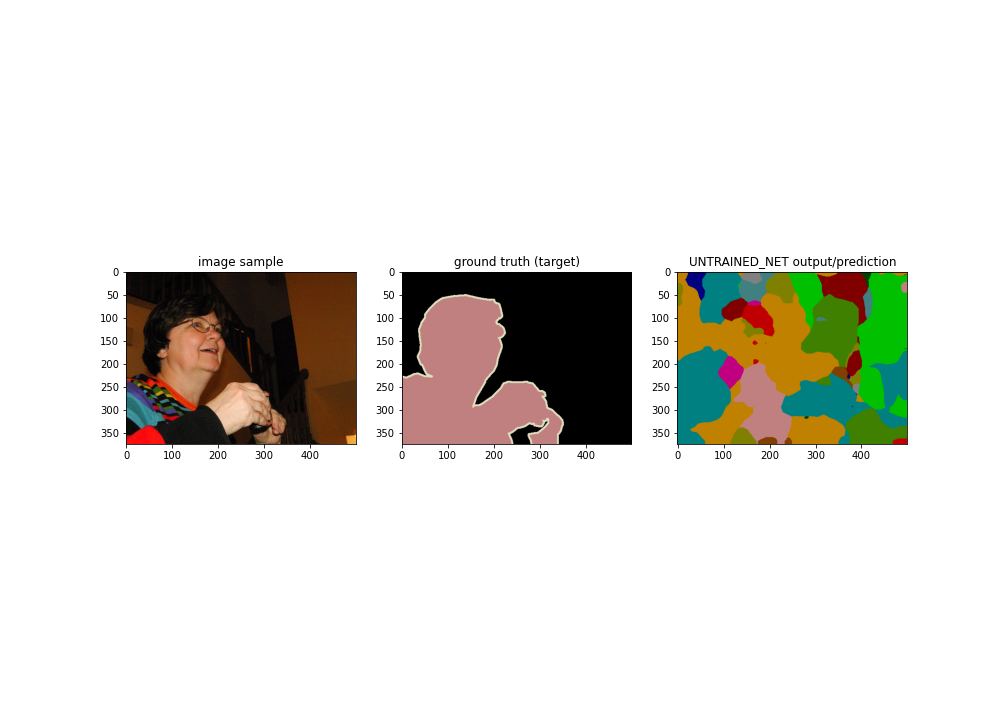

In [320]:
untrained_net = MyNet(21).eval()
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
untrained_output = untrained_net.forward(sample_img[None])

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,3,1)
plt.title('image sample')
ax.imshow(sample1[0])
ax = fig.add_subplot(1,3,2)
plt.title('ground truth (target)')
ax.imshow(sample1[1])
ax = fig.add_subplot(1,3,3)
plt.title('UNTRAINED_NET output/prediction')
ax.imshow(colorize_mask(torch.argmax(untrained_output, dim=1).numpy()[0]))



#### Implement the loss function (Cross Entropy Loss). 


In [321]:
# Student Answer:
class MyCrossEntropyLoss():
    def __init__(self, ignore_index):
        self.ignore_index = ignore_index
        
    def __call__(self, untrained_output, sample_target):
        # F.log_softmax(input, dim=None, _stacklevel=3, dtype=None)
        # F.nll_loss(input, target, weight=None, size_average=None, 
        #            ignore_index=-100, reduce=None, reduction='mean')
        softmax = F.log_softmax(untrained_output, dim = 1)
        return F.nll_loss(softmax, sample_target, ignore_index = self.ignore_index)

#### Compare against the existing CrossEntropyLoss function on your sample output from our neural network.

In [322]:
criterion = nn.CrossEntropyLoss(ignore_index=255)

print(criterion(untrained_output, sample_target[None]))

my_criterion = MyCrossEntropyLoss(ignore_index=255)

print(my_criterion(untrained_output, sample_target[None]))
    

tensor(3.0670, grad_fn=<NllLoss2DBackward>)
tensor(3.0670, grad_fn=<NllLoss2DBackward>)



####  Use standard function `eval_semantic_segmentation` (already imported from chainerCV) to compute "mean intersection over union" for the output of UNTRAINED_NET on sample1 (`untrained_output`) using the target for sample1. 

In [323]:
# Write code to propely compute 'pred' and 'gts' as arguments for function 'eval_semantic_segemntation'
# note that at the begining we define img1, target1 = sample1
#img1, target1 = sample1

print(untrained_output.shape)
# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, 
#       diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined
labels = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'cat',
    8: 'car',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'pottedplant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'TV_monitor',
    255: "void"
}

# calculate the predict labels and gt labels
# 1. predict labels
pred = torch.argmax(untrained_output, dim=1).numpy()[0]

# 2. gt labels
# calculate the same in Q5(c)
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf = eval_semantic_segmentation(pred[None], gts[None])

print("mIoU for the sample image / ground truth pair: {}".format(conf['miou']))

torch.Size([1, 21, 375, 500])
mIoU for the sample image / ground truth pair: 0.009401026708788052


#### Write the validation loop.

In [324]:
def validate(val_loader, net):
    
    iou_arr = []
    net.eval()
    val_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
        
            inputs, masks = data

            if USE_GPU:
                # use GPU
                inputs = inputs.cuda()
                masks = masks.cuda()
                net = net.cuda()
            else: 
                # use CPU
                inputs = inputs.cpu()
                masks = masks.cpu()
                net = net.cpu()
                
            
            # Write me
            # same as in Classification_Notebook_CS484_UW.ipynb
            output = net(inputs)
            val_loss += MyCrossEntropyLoss(ignore_index=255)(output,masks)
            preds = torch.argmax(output, dim = 1).numpy()
            gts = torch.from_numpy(np.array(masks, dtype = np.int32)).long().numpy()
            gts[gts == 255] = -1

            # Hint: make sure the range of values of the ground truth is what you expect

            conf = eval_semantic_segmentation(preds, gts)

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

#### Run the validation loop for UNTRAINED_NET against the sanity validation dataset.

In [325]:
%%time
print("mIoU over the sanity dataset:{}".format(validate(sanity_loader, untrained_net)[1]))

mIoU over the sanity dataset:0.009401026708788052
CPU times: user 1.08 s, sys: 122 ms, total: 1.21 s
Wall time: 1.1 s



#### Define an optimizer to train the given loss function.




In [326]:
def get_optimizer(net):
    # use the sampe optimizer as in Classification_Notebook_CS484_UW.ipynb
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer




####  Write the training loop to train the network. 


In [327]:
def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, masks = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            mask = mask.cuda()
        
        # Write me
        # same as in Classification_Notebook_CS484_UW.ipynb
        optimizer.zero_grad()
        main_loss = net(inputs, gts=masks)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()
        
        # loss_graph.append() Populate this list to graph the loss
        
    return main_loss

#### Create OVERFIT_NET and train it on the single image dataset.


Starting Training...


<IPython.core.display.Javascript object>


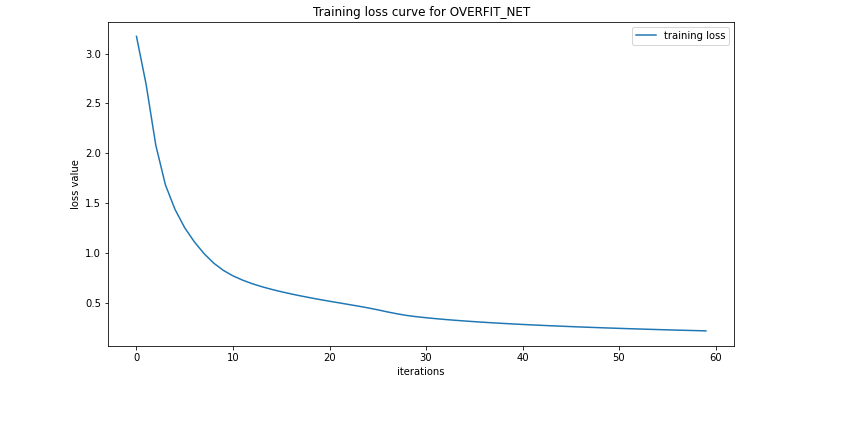

Epoch: 0 Loss: 3.1733756065368652
Epoch: 1 Loss: 2.6907355785369873
Epoch: 2 Loss: 2.0817627906799316
Epoch: 3 Loss: 1.6824922561645508
Epoch: 4 Loss: 1.4351547956466675
Epoch: 5 Loss: 1.2521353960037231
Epoch: 6 Loss: 1.1106537580490112
Epoch: 7 Loss: 0.9932776689529419
Epoch: 8 Loss: 0.8978433012962341
Epoch: 9 Loss: 0.8248823285102844
Epoch: 10 Loss: 0.769737184047699
Epoch: 11 Loss: 0.7267917394638062
Epoch: 12 Loss: 0.6909821629524231
Epoch: 13 Loss: 0.6608249545097351
Epoch: 14 Loss: 0.6344200968742371
Epoch: 15 Loss: 0.6107886433601379
Epoch: 16 Loss: 0.589042067527771
Epoch: 17 Loss: 0.5689800977706909
Epoch: 18 Loss: 0.5502417683601379
Epoch: 19 Loss: 0.5321215391159058
Epoch: 20 Loss: 0.5151316523551941
Epoch: 21 Loss: 0.4989590644836426
Epoch: 22 Loss: 0.4823892116546631
Epoch: 23 Loss: 0.46586501598358154
Epoch: 24 Loss: 0.44832929968833923
Epoch: 25 Loss: 0.4290023148059845
Epoch: 26 Loss: 0.40822023153305054
Epoch: 27 Loss: 0.38912713527679443
Epoch: 28 Loss: 0.3725414872

In [328]:
%%time
%matplotlib notebook

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU). 
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets 
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training. 
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net. 
overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
overfit_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# You can change the number of EPOCHS
EPOCH = 60

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

#### Qualitative and quantitative evaluation of predictions (untrained vs overfit nets) - fully implemented.

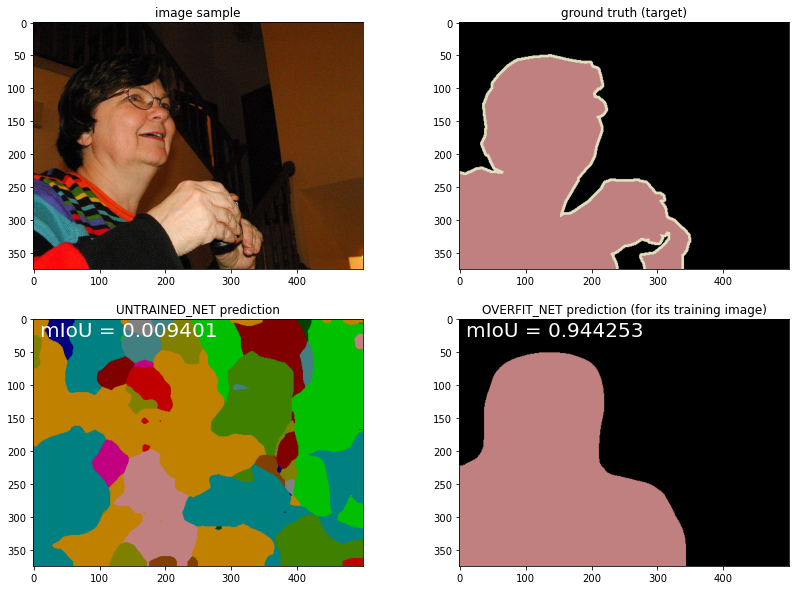

In [329]:
# switch back to evaluation mode
overfit_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for its training image)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

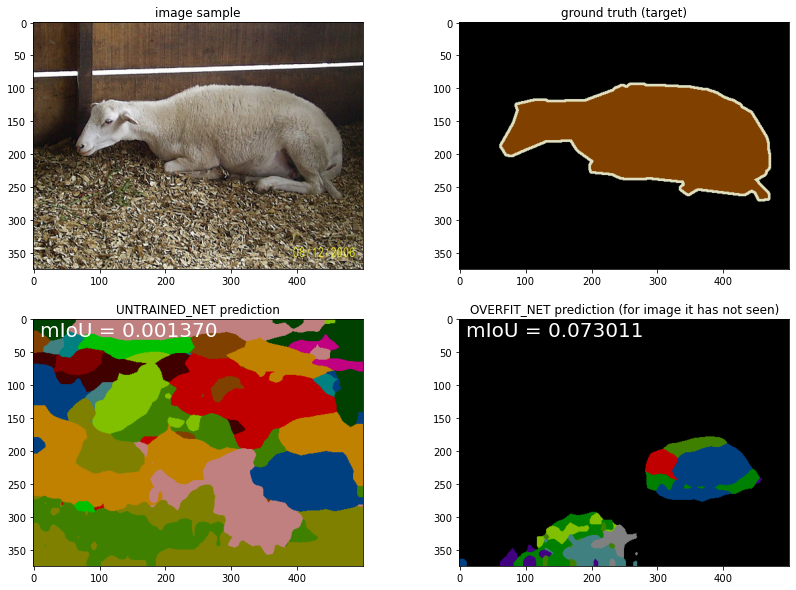

In [330]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

#### Run the validation loop for OVERFIT_NET against the sanity dataset (an image it was trained on) - fully implemented

In [331]:
%%time
print("mIoU for OVERFIT_NET over its training image:{}".format(validate(sanity_loader, overfit_net)[1]))

mIoU for OVERFIT_NET over its training image:0.9442527581761997
CPU times: user 1.26 s, sys: 156 ms, total: 1.42 s
Wall time: 1.68 s


### WARNING: For the remaining part. it is advisable to switch to GPU mode as running each validation and training loop on the whole training set takes over an hour on CPU (there are several such loops below). 


####  Evaluate UNTRAINED_NET and OVERFIT_NET on validation dataset.
##### Run the validation loop for UNTRAINED_NET against the validation dataset:

In [332]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)[1]))

mIoU for UNTRAINED_NET over the entire dataset:0.0027920566160010477
CPU times: user 25min 30s, sys: 3min, total: 28min 31s
Wall time: 26min 54s


##### Run the validation loop for OVERFIT_NET against the validation dataset (it has not seen): 

In [333]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for OVERFIT_NET over the validation dataset:{}".format(validate(val_loader, overfit_net)[1]))

mIoU for OVERFIT_NET over the validation dataset:0.08192394698794468
CPU times: user 24min 47s, sys: 2min 51s, total: 27min 38s
Wall time: 25min 13s


####  Create TRAINED_NET and train it on the full training dataset:

Starting Training...


<IPython.core.display.Javascript object>


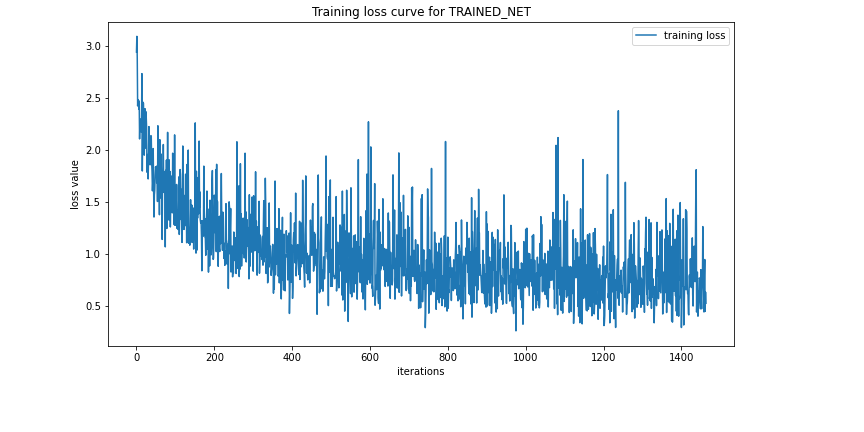

Epoch: 0 Loss: 0.806950569152832
Epoch: 1 Loss: 1.0074036121368408
Epoch: 2 Loss: 0.9855901002883911
Epoch: 3 Loss: 0.529554545879364
CPU times: user 2h 31min 6s, sys: 13min 19s, total: 2h 44min 25s
Wall time: 4h 47min 31s


In [334]:
%%time
%matplotlib notebook

# This training will be very slow on a CPU (>1hour per epoch). Ideally, this should be run in GPU mode (USE_GPU=True) 
# taking only a few minutes per epoch (depending on your GPU and batch size). Thus, before proceeding with this excercise,
# it is highly advisable that you first finish debugging your net code. In particular, make sure that OVERFIT_NET behaves 
# reasonably, e.g. its loss monotonically decreases during training and its output is OK (for the image it was trained on). 
# Below we create another (deep) copy of untrained_net. Unlike OVERFIT_NET it will be trained on a full training dataset.
trained_net = copy.deepcopy(untrained_net)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=255)


# You can change the number of EPOCHS below. Since each epoch for TRAINED_NET iterates over all training dataset images,
# the number of required epochs could be smaller compared to OFERFIT_NET where each epoch iterates over one-image-dataset)
EPOCH = 4

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAINED_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()    
    print("Epoch: {} Loss: {}".format(e, loss))
    
%matplotlib inline

####  Qualitative and quantitative evaluation of predictions (OVERFIT_NET vs TRAINED_NET):

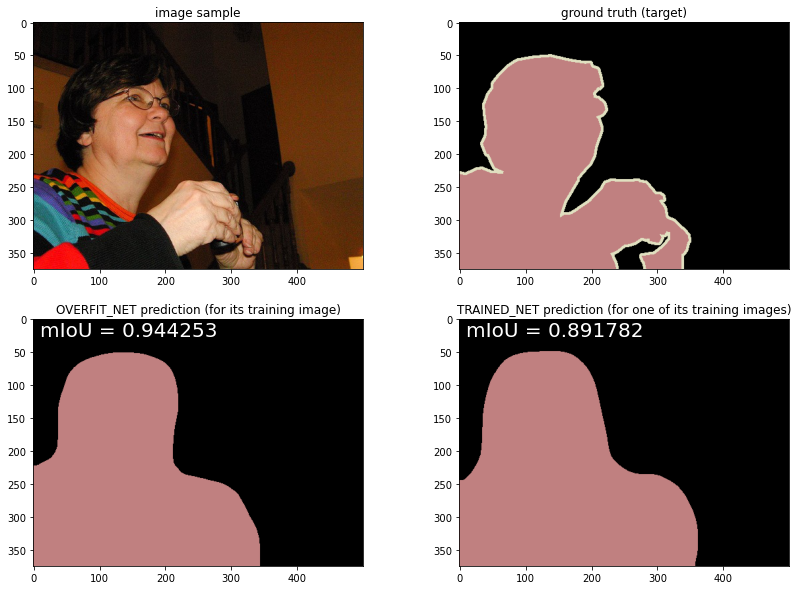

In [335]:
# switch back to evaluation mode
trained_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for its training image)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for one of its training images)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

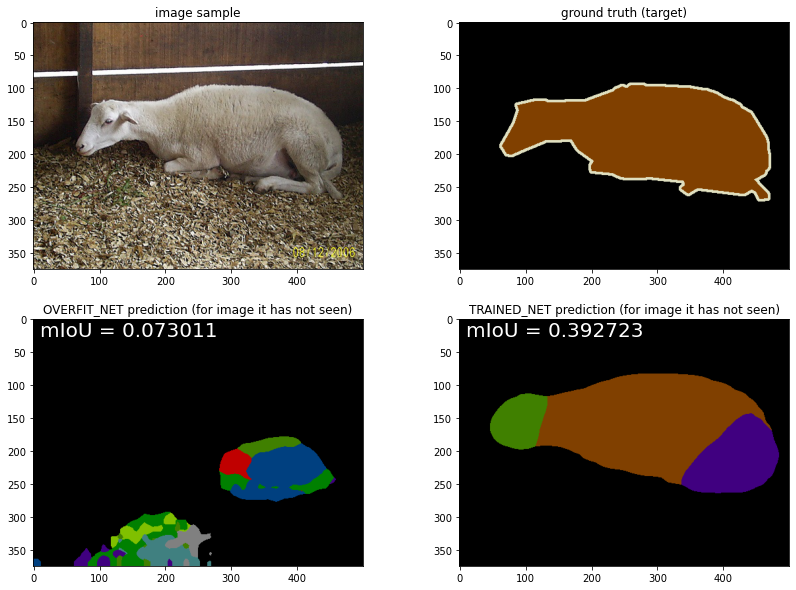

In [336]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

####  Evaluate TRAINED_NET on validation dataset.
##### Run the validation loop for TRAINED_NET against the validation dataset (it has not seen): 

In [337]:
%%time
# This will be slow on CPU (around 1 hour). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for TRAINED_NET over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

mIoU for TRAINED_NET over the validation dataset:0.49457657380386366
CPU times: user 24min 46s, sys: 2min 53s, total: 27min 39s
Wall time: 44min 22s
